# Fetch Rewards Coding Exercise - Data Analyst

In [1]:
import pandas as pd
from ast import literal_eval
import json
import datetime
from sqlalchemy import create_engine
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Read in Data
Read in Receipts, Brands and Users data

### Receipts
In this section, I read in json file, clean the data by removing unnecessary words, convert time format from UTC to datetime, and pull of the data that is stored in `rewardsReceiptItemList` column

In [2]:
receipts = pd.read_json('receipts.json',lines=True)

In [3]:
#receipt
receipts = receipts.fillna({'rewardsReceiptItemList': '{}', 'finishedDate': '{}', 'pointsAwardedDate': '{}', 'purchaseDate': '{}'})

In [4]:
#functions for data cleaning
def clean_column_keep_dic_value(df, col, key):  
    all_list=[]
    for i in range(len(df)):
        if df[col].iloc[i] == '{}': 
            all_list.append('{}')
        else: 
            all_list.append(df[col].iloc[i][key])
    return all_list

def convert_time(df, col):
    time_list = []
    for i in range(len(df)):
        if df[col].iloc[i] == '{}': 
            time_list.append('')
        else:
            time_list.append(datetime.datetime.fromtimestamp(df[col].iloc[i] / 1e3)) 
    return time_list

In [5]:
#Remove unnecessary words and clean data
receipts['_id'] = clean_column_keep_dic_value(receipts, '_id', '$oid')
receipts['createDate'] = clean_column_keep_dic_value(receipts, 'createDate', '$date')
receipts['dateScanned'] = clean_column_keep_dic_value(receipts, 'dateScanned', '$date')
receipts['modifyDate'] = clean_column_keep_dic_value(receipts, 'modifyDate', '$date')
receipts['finishedDate'] = clean_column_keep_dic_value(receipts, 'finishedDate', '$date')
receipts['pointsAwardedDate'] = clean_column_keep_dic_value(receipts, 'pointsAwardedDate', '$date')
receipts['purchaseDate'] = clean_column_keep_dic_value(receipts, 'purchaseDate', '$date')

In [6]:
#convert time from UTC to datetime
receipts['createDate'] = convert_time(receipts, 'createDate')
receipts['dateScanned'] = convert_time(receipts, 'dateScanned')
receipts['modifyDate'] = convert_time(receipts, 'modifyDate')
receipts['finishedDate'] = convert_time(receipts, 'finishedDate')
receipts['pointsAwardedDate'] = convert_time(receipts, 'pointsAwardedDate')
receipts['purchaseDate'] = convert_time(receipts, 'purchaseDate')

#only keep the date
receipts['createDate'] =  receipts['createDate'].dt.date
receipts['dateScanned'] = receipts['dateScanned'].dt.date
receipts['modifyDate'] = receipts['modifyDate'].dt.date
receipts['finishedDate'] = receipts['finishedDate'].dt.date
receipts['pointsAwardedDate'] = receipts['pointsAwardedDate'].dt.date
receipts['purchaseDate'] = receipts['purchaseDate'].dt.date

Clean `rewardsReceiptItemList` column. The first step is to explode the `rewardsReceiptItemList` field as it contains lists of receipts(using literal_eval function from ast package). Then I split each dictionary and get the sub-columns (using the json_normalize function in pandas). At the end I join the new created data with the original receipts data frame.

In [7]:
receipts = receipts.explode('rewardsReceiptItemList')
receipts.reset_index(inplace=True)

In [8]:
receipts = receipts.fillna({'rewardsReceiptItemList':'{}'})
receipts['rewardsReceiptItemList'] = receipts['rewardsReceiptItemList'].apply(lambda x:str(x))
receipts['rewardsReceiptItemList'] = receipts['rewardsReceiptItemList'].apply(literal_eval)

In [9]:
receipts_norm = pd.json_normalize(receipts['rewardsReceiptItemList'],errors='ignore',record_prefix='rewardsReceiptItemList').add_prefix('rewardsReceiptItemList.')

In [10]:
receipts_final = pd.merge(receipts, receipts_norm, left_index=True, right_index=True, how='outer')
receipts_final = receipts_final.drop(columns=['rewardsReceiptItemList'],axis=1)

In [11]:
receipts_final.head()

,index,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,...,rewardsReceiptItemList.itemNumber,rewardsReceiptItemList.originalMetaBriteQuantityPurchased,rewardsReceiptItemList.pointsEarned,rewardsReceiptItemList.targetPrice,rewardsReceiptItemList.competitiveProduct,rewardsReceiptItemList.originalFinalPrice,rewardsReceiptItemList.originalMetaBriteItemPrice,rewardsReceiptItemList.deleted,rewardsReceiptItemList.priceAfterCoupon,rewardsReceiptItemList.metabriteCampaignId
0,0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03,2021-01-03,NaT,2021-01-03,NaT,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Brands
In this section, I read in Brands data and pull out the data that is stored in `cpg` column and create new columns.

In [12]:
brands = pd.read_json('brands.json',lines=True)

In [13]:
#Remove unnecessary words and clean data                     
brands['_id'] = clean_column_keep_dic_value(brands, '_id', '$oid')

In [14]:
#extract the data in cpg column from brands
set().union(*(d.keys() for d in brands['cpg']))
brands_norm = pd.json_normalize(brands['cpg'])
brands_norm = brands_norm.add_prefix('cpg.')
brands_final = pd.merge(brands, brands_norm, left_index=True, right_index=True, how='outer')
brands_final = brands_final.drop(columns=['cpg'],axis=1)

### Users
In this section, I read in Users data, clean the data by removing unnecessary words, convert time format from UTC to datetime.

In [15]:
users = pd.read_json('users.json',lines=True)

In [16]:
users = users.fillna({'createdDate':'{}', 'lastLogin':'{}'})

In [17]:
#Remove unnecessary words and clean data
users['_id'] = clean_column_keep_dic_value(users, '_id', '$oid')
users['createdDate'] = clean_column_keep_dic_value(users, 'createdDate', '$date')
users['lastLogin'] = clean_column_keep_dic_value(users, 'lastLogin', '$date')

In [18]:
users = users.fillna({'createdDate':'{}', 'lastLogin':'{}'})

In [19]:
#convert time from UTC to datetime
users['createdDate'] = convert_time(users, 'createdDate')
users['lastLogin'] = convert_time(users, 'lastLogin')

#only keep the date
users['createdDate'] = users['createdDate'].dt.date
users['lastLogin'] = users['lastLogin'].dt.date

# Data Quality Check
In this section, I joined tables to see whether keys in a table matched keys in another table. I also checked the null value percentage for each column, and visualized the numerical data distribution. 


I found that:
1. There are lots of `userId` in the Receipts table that could not match the `_id` in Users table. 
2. There are lots of `brandcodes ` in the Receipts table that could not match the `brandcodes` in the Brands table. This could be problematic when we are doing analysis on brand level. 
3. In the Receipts, Users, and Brands tables, there are many columns with a high percentage of missing values, so we should work on gathering data more completely, so that we can make more accurate analysis in the future. 
4. The distribution chart shows that there are some outliers in some columns. (for example, pointsEarned, totalSpent) We should discuss with stakeholders to see whether these are abnormal data points.


## Join each table to make sure there are not quality problem when joining tables

In [20]:
receipts_brands = receipts_final.merge(brands[['brandCode']].drop_duplicates(), left_on='rewardsReceiptItemList.brandCode', right_on='brandCode', how='left')

In [21]:
receipts_brands.brandCode.unique()

array([nan, 'PEPSI', 'DORITOS', 'KLEENEX', 'KNORR', 'SWANSON', 'YUBAN',
       'DOLE CHILLED FRUIT JUICES', 'KRAFT', 'TOSTITOS', 'RICE-A-RONI',
       'KETTLE BRAND', 'PEPPERIDGE FARM', 'STOVE TOP', 'NATURE VALLEY',
       'ARNOLD', 'GREY POUPON', 'KLONDIKE', 'CRACKER BARREL', 'QUAKER',
       'PHILADELPHIA', 'TACO BELL', 'COTTONELLE', "HELLMANN'S/BEST FOODS",
       'COOL WHIP', 'MOUNTAIN DEW', 'JELL-O', 'CLASSICO', 'LUNCHABLES',
       'OSCAR MAYER', 'PLANTERS', 'VELVEETA', 'PREGO', 'PACIFIC FOODS',
       'ORE-IDA', 'FINISH', 'JUST CRACK AN EGG', 'SARGENTO', 'CHEETOS',
       'V8', 'HUGGIES', 'VIVA'], dtype=object)

In [22]:
receipts_brands_users = receipts_brands.merge(users.drop_duplicates(), left_on='userId', right_on='_id', how='left')

In [23]:
# receipts_brands_users.isna().sum()

In [24]:
receipts_brands_users.head()

,index,_id_x,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,...,rewardsReceiptItemList.priceAfterCoupon,rewardsReceiptItemList.metabriteCampaignId,brandCode,_id_y,active,createdDate,lastLogin,role,signUpSource,state
0,0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,500.0,...,NaN,NaN,NaN,5ff1e1eacfcf6c399c274ae6,True,2021-01-03,2021-01-03,consumer,Email,WI
1,1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,150.0,...,NaN,NaN,NaN,5ff1e194b6a9d73a3a9f1052,True,2021-01-03,2021-01-03,consumer,Email,WI
2,1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,150.0,...,NaN,NaN,NaN,5ff1e194b6a9d73a3a9f1052,True,2021-01-03,2021-01-03,consumer,Email,WI
3,2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03,2021-01-03,NaT,2021-01-03,NaT,5.0,...,NaN,NaN,NaN,5ff1e1f1cfcf6c399c274b0b,True,2021-01-03,2021-01-03,consumer,Email,WI
4,3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03,2021-01-03,2021-01-03,2021-01-03,2021-01-03,5.0,...,NaN,NaN,NaN,5ff1e1eacfcf6c399c274ae6,True,2021-01-03,2021-01-03,consumer,Email,WI


In [25]:
receipts_brands_users[['brandCode']].isna().sum()

brandCode    6752
dtype: int64

In [26]:
#the user_id in Users table
receipts_brands_users[['_id_y']].isna().sum()

_id_y    2610
dtype: int64

## 1. check null percentage

In [27]:
def null_percentage_calc(df, width, height, show_plot=True):  
    null_percentage = round((df.isna().sum()/len(df))*100, 2).to_frame().rename(columns={0:'percentage'}).sort_values(by='percentage', ascending=False)
    if show_plot == True:
        plt.figure(figsize=(width, height))
        null_percentage.plot(kind='barh')
        plt.xlabel("Null Value Percentage")
        plt.ylabel("Column Names")
    return null_percentage


### Brand Data Null Value Percentage

,percentage
categoryCode,55.70
topBrand,52.44
brandCode,20.05
category,13.28
_id,0.00
barcode,0.00
name,0.00
cpg.$ref,0.00
cpg.$id.$oid,0.00


<Figure size 720x576 with 0 Axes>

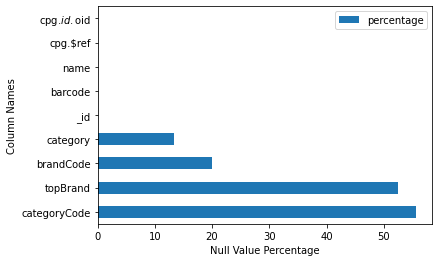

In [28]:
null_percentage_calc(brands_final, 10, 8)

### Users Data Null Value Percentage

,percentage
lastLogin,12.53
state,11.31
signUpSource,9.70
_id,0.00
active,0.00
createdDate,0.00
role,0.00


<Figure size 720x576 with 0 Axes>

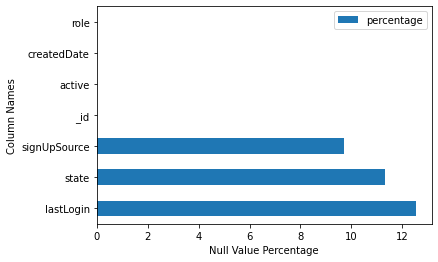

In [29]:
null_percentage_calc(users, 10, 8)

### Receipts Data (columns except data in `rewardsReceiptItemList` column) Null Value Percentage

,percentage
finishedDate,19.12
bonusPointsEarned,18.98
bonusPointsEarnedReason,18.98
pointsAwardedDate,17.63
pointsEarned,15.28
purchasedItemCount,6.56
purchaseDate,6.21
totalSpent,5.89
index,0.00
_id,0.00


<Figure size 720x576 with 0 Axes>

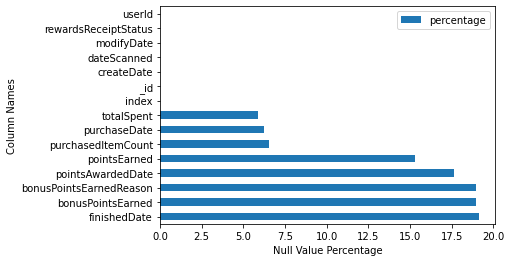

In [30]:
null_percentage_calc(receipts_final[['index', '_id', 'bonusPointsEarned', 'bonusPointsEarnedReason','createDate', 'dateScanned', 'finishedDate', 
                                     'modifyDate','pointsAwardedDate', 'pointsEarned', 'purchaseDate','purchasedItemCount', 'rewardsReceiptStatus', 'totalSpent', 'userId']], 10, 8)

### Data in `rewardsReceiptItemList` Null Value Percentage

In [31]:
null_percentage_calc(receipts_final[[col for col in receipts_final if col.startswith('rewardsReceiptItemList')]],10, 8, False)

,percentage
rewardsReceiptItemList.deleted,99.88
rewardsReceiptItemList.originalMetaBriteItemPrice,99.88
rewardsReceiptItemList.originalFinalPrice,99.88
rewardsReceiptItemList.originalMetaBriteDescription,99.86
rewardsReceiptItemList.originalMetaBriteQuantityPurchased,99.80
rewardsReceiptItemList.originalMetaBriteBarcode,99.04
rewardsReceiptItemList.itemNumber,97.93
rewardsReceiptItemList.userFlaggedDescription,97.22
rewardsReceiptItemList.needsFetchReviewReason,97.03
rewardsReceiptItemList.competitorRewardsGroup,96.27


## 2.Check data distribution and find potential outliers

In [32]:
def plot_col_distribution(df, bins):
    for col in df.columns:
        if ((df[col].dtype) == 'float64'):
            df[col].hist(bins=bins)
            plt.title(col + " Distribution")
            plt.show()

def boxplot(df):
    ax = sns.boxplot(data=df, orient="h", palette="Set2")

### Distribution for Numerical Data in Receipts

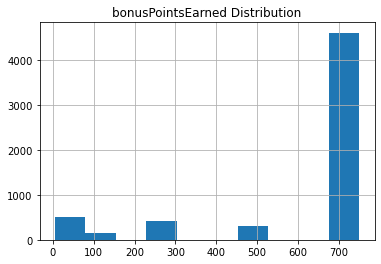

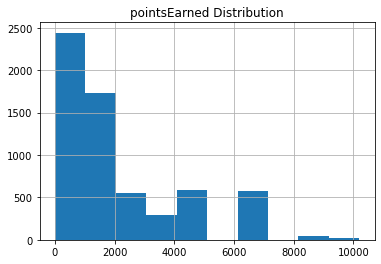

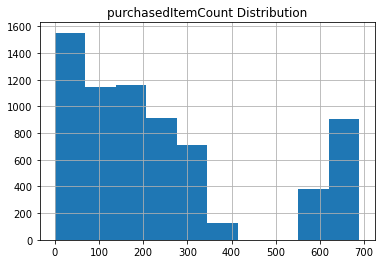

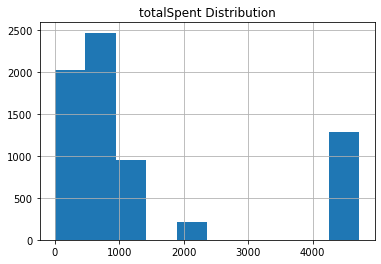

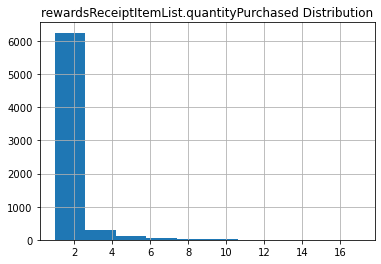

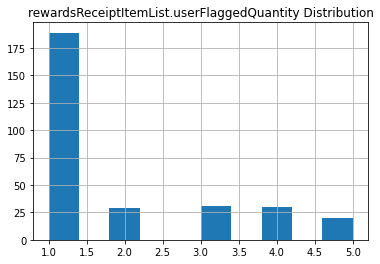

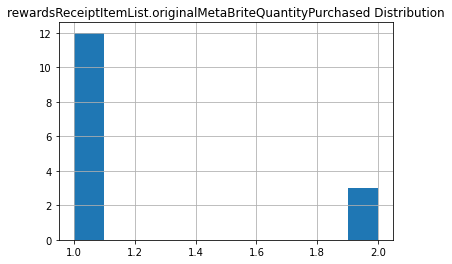

In [33]:
plot_col_distribution(receipts_final, 10)

### Boxplot for Numerical Data in Receipts

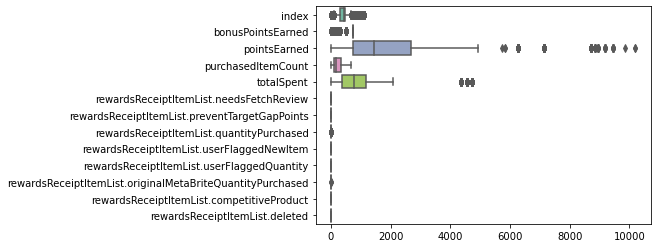

In [34]:
boxplot(receipts_final)

<AxesSubplot:xlabel='purchasedItemCount', ylabel='totalSpent'>

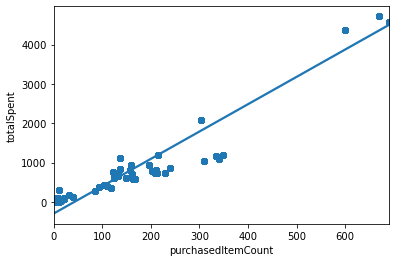

In [35]:
#check whether purchasedItemCount and totalSpent have positive correlation
sns.regplot(x="purchasedItemCount", y="totalSpent", data=receipts_final)

In [36]:
receipts_final.describe()

,index,bonusPointsEarned,pointsEarned,purchasedItemCount,totalSpent,rewardsReceiptItemList.quantityPurchased,rewardsReceiptItemList.userFlaggedQuantity,rewardsReceiptItemList.originalMetaBriteQuantityPurchased
count,7381.000000,5980.000000,6253.000000,6897.000000,6946.000000,6767.000000,299.000000,15.000000
mean,422.701937,625.901839,2175.583688,240.764680,1368.577206,1.386139,1.872910,1.200000
std,176.929482,244.395911,2175.733326,221.805453,1588.959342,1.204363,1.314823,0.414039
min,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,318.000000,750.000000,750.000000,93.000000,373.550000,1.000000,1.000000,1.000000
50%,425.000000,750.000000,1447.000000,167.000000,776.790000,1.000000,1.000000,1.000000
75%,462.000000,750.000000,2685.800000,335.000000,1183.100000,1.000000,3.000000,1.000000
max,1118.000000,750.000000,10199.800000,689.000000,4721.950000,17.000000,5.000000,2.000000


# Write a query that directly answers a predetermined question from a business stakeholder

Before pulling the data from SQL, I drop the rows where `totalSpent` and `purchasedItemCount` in Receipts is null, because when calculating the average spend of total item purchased, filling in null values will make the analysis inaccurate. 

In [37]:
receipts_final = receipts_final.dropna(subset=['totalSpent', 'purchasedItemCount'], how='all')
receipts_final = receipts_final.dropna(subset=['purchasedItemCount'], how='all')

Connect with SQLite database through SQL Alchemy python (https://docs.sqlalchemy.org/en/14/dialects/sqlite.html) to implement the SQL database for the queries.

In [38]:
engine = create_engine('sqlite://', echo=False)

In [39]:
users.drop_duplicates(subset=['_id']).to_sql('users',con=engine)

In [40]:
receipts_final.columns = receipts_final.columns.str.replace(".", "_")

<ipython-input-40-10e76c51b192>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  receipts_final.columns = receipts_final.columns.str.replace(".", "_")


In [41]:
receipts_final.to_sql('receipts',con=engine)

In [42]:
brands_final.to_sql('brands',con=engine)

In [43]:
receipts.rewardsReceiptStatus.unique()

array(['FINISHED', 'REJECTED', 'FLAGGED', 'SUBMITTED', 'PENDING'],
      dtype=object)

### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

Since I didn't see 'Accepted' as a status in rewardsReceiptStatus, I'm assuming `FINISHED` represents `Accepted`. I will follow up with stakeholders to see whether I'm interpreting it correctly in the email.

In [44]:
engine.execute('''SELECT rewardsReceiptStatus, ROUND(AVG(totalSpent), 2) as avg_spent
                  FROM receipts
                  WHERE rewardsReceiptStatus = 'FINISHED' or rewardsReceiptStatus = 'REJECTED'
                  GROUP BY rewardsReceiptStatus''').fetchall()

[('FINISHED', 1244.37), ('REJECTED', 19.54)]

### When considering total number of items purchased from receipts with rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [45]:
engine.execute('''SELECT rewardsReceiptStatus, ROUND(SUM(purchasedItemCount), 2) as total_num_purchased
                  FROM receipts
                  WHERE rewardsReceiptStatus = 'FINISHED' or rewardsReceiptStatus = 'REJECTED'
                  GROUP BY rewardsReceiptStatus''').fetchall()

[('FINISHED', 1364998.0), ('REJECTED', 740.0)]

# Communicate with Stakeholders

Hi all,

I've been working on the analysis of finding the average spend and total number of items purchased whose rewardsReceiptStatus is **Accepted or Rejected**. I want to update my progress and get clarity on some questions.

I found that the average spend where rewardsReceiptStatus for **Finished is 1244.37, Rejected is 19.54**, and the total number of items purchased for **Finished is 1364998, Rejected is 740**. Both average spend and total number of items purchased with rewardsReceiptStatus =FINISHED is much higher than items with rewardsReceiptStatus  = REJECTED. 

Questions I want to clarify:

1. Data Definition Clarification For The Analysis
In the current analysis, I’m assuming that **Finished = Accepted** because there are no rows  where rewardsReceiptStatus is **Accepted**. Correct me if I am wrong, and I will update the analysis.

2. Data Format
The current data is not well structured. For example, rewardsReceiptItemList contains a blob of information, is there a way we can more efficiently store this data? This format would cost a lot of time for data wrangling in the future when we scale to millions of rows. It would be helpful for us to spend time discussing restructuring the current data frame so that we could work more efficiently in the future.




3. Data Quality Issues -  Missing Value and Outliers 
After drawing box plots, looking at numerical data distributions, and calculating the null value percentage, I found that there are some missing values in the Users, Brands, and Receipts tables. There is a disproportionately large number of null values in the `rewardsReceiptItemList` column. Could you let me know what the data collection process was, so we can brainstorm methods to improve data quality and reduce the number of null values in the future? There are also lots of outliers in the dataset. For example, a few transactions earned 6000+ points, and spent 4000+ dollars. Are these real transactions?

Some `userId` from the Receipts table don’t match the `_id` in the Users table. This might happen because our customer/user database isn’t large enough yet. It would be helpful for us to discuss some alternative methods to collect more user information. Having sufficient customer/user data will help further customer analysis. Another data issue I want to address is that there are a lot of brandcodes in the Receipts table that do not exist in the Brands data. This could be problematic when we are doing analysis on a brand level. 

Let me know what your thoughts are. We can schedule a meeting to clarify the above questions and discuss further analysis.

Thanks!

Best Regards,
Shana